# Masterarbeit (Batch-Tool)

In [1]:
# Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

#Use notebook for interactive plots
#%matplotlib notebook
%matplotlib inline

In [2]:
# JSON Lib
! pip install demjson
import demjson

In [3]:
# Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# WordCloud
! pip install wordcloud
from wordcloud import WordCloud

In [5]:
# Show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Dateien ausgeben und Variablen setzen
dir_var = "../"
! ls -al ../

total 32
drwxr-xr-x 10 root   root    320 Dec 11 14:25 .
drwsrwsr-x  1 jovyan users  4096 Dec 12 13:40 ..
drwxr-xr-x 33 jovyan users  1056 Dec 11 14:25 DS-08-10-2020
drwxr-xr-x 18 jovyan users   576 Dec 11 14:25 DS-22-10-2020
drwxr-xr-x 14 jovyan users   448 Dec 12 14:38 .git
-rw-r--r--  1 jovyan users    43 Dec 11 14:25 .gitattributes
-rw-r--r--  1 jovyan users    30 Dec 11 14:25 .gitignore
-rw-r--r--  1 jovyan users 11357 Dec 11 14:25 LICENSE
drwxr-xr-x  5 jovyan users   160 Dec 12 14:39 notebooks
-rw-r--r--  1 jovyan users   102 Dec 11 14:25 README.md


## Process jobs

In [7]:
dfInputFiles = pd.read_excel(dir_var + "notebooks/inputFiles.xlsx", header=None, names=["inputName", "inputPath", "inputType", "inputId"])

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [8]:
# Take only samples
dfInputFiles = dfInputFiles.head(2)
#dfInputFiles = dfInputFiles[dfInputFiles.inputName.str.contains("FREIHEIT")]

### Overview jobs

In [9]:
dfInputFiles

,inputName,inputPath,inputType,inputId
0,FREIHEITS-CHAT,DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat,public_supergroup,9717909816
1,Oliver Janich öffentlich,DS-08-10-2020/ChatExport_2020-09-25-janich,public_channel,9808932799


### Transform jobs

In [10]:
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + filePath + "/result.json", encoding='utf-8')
    return dF

In [11]:
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [12]:
def checkIsFormattedText(text):
    textString = str(text)
    if(textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    else:
        return False

In [13]:
def convertToValidText(processedIsFormattedText, text):
    
    if(processedIsFormattedText != True):
        #Is no JSON
        return text;
    else:
        #Is json try to parse
        try:
            jsonList = demjson.decode(str(text), encoding='utf8')

            returnString = ""

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isFormatted = messageString.startswith("{") and messageString.endswith("}")

                if(isFormatted):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "italic"):
                        #text included
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "underline"):
                        #text included
                        returnString = returnString + subJsonString["text"]
                    
                    elif(subJsonType == "email"):
                        #text included (dont return)
                        returnString = returnString
                        
                    elif(subJsonType == "text_link"):
                        #text and href included (only return text)
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "link"):
                        #text included (dont return)
                        returnString = returnString
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included (only return text)
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "bot_command"):
                        #text included (dont return)
                        returnString = returnString 
                        
                    elif(subJsonType == "code"):
                        #text included (dont return)
                        returnString = returnString
                        
                    elif(subJsonType == "phone"):
                        #text included (dont return)
                        returnString = returnString
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnString = returnString + subJsonString["text"]
                        
                    elif(subJsonType == "bank_card"):
                        #text included (dont return)
                        returnString = returnString
                        
                    else:
                        print("- Error: Unknown type " + subJsonType)
                        returnString = returnString

                else:
                    # Is Normal Sub String
                    returnString = returnString + messageString

            return returnString
        
        except:
            #Parser error
            print("- Warn: Json parser error (set return text to inputText) >>" + text + "<<")
            return text

In [14]:
# Timer Start
timeStartGlobal = time.time()

# Add Key = filePath / Value = DataFrame (Metadata)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Messages)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    timeStartSingle = time.time()
    print("[Process now " + fP + "]")
    dfMessages = convertToDataFrameMessages(fP, dictMeta)
    
    dfMessages["processedChannelFilePath"]  = fP
    dfMessages["processedChannelType"]      = dictMeta[fP].type.iloc[0]
    dfMessages["processedRawTextSize"]      = dfMessages["text"].str.len()
    dfMessages["processedIsFormattedText"]  = dfMessages["text"].apply(checkIsFormattedText)
    dfMessages["processedValidText"]        = dfMessages.apply(lambda x: convertToValidText(x.processedIsFormattedText, x.text), axis=1)
    dfMessages["processedValidTextSize"]    = dfMessages["processedValidText"].str.len()
    
    dictMessages[fP] = dfMessages
    timeEndSingle = time.time()
    print('{:5.3f}s'.format(timeEndSingle-timeStartSingle))

# All Messages to DataFrame
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    
    print("[Append now " + fP + "]")
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)

# Print Time
timeEndGlobal = time.time()
print()
print("[Finished global]")
print('{:5.3f}s'.format(timeEndGlobal-timeStartGlobal))

[Process now DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat]
- Warn: Json parser error (set return text to inputText) >>[Nachweis hier einfügen]<<
236.993s
[Process now DS-08-10-2020/ChatExport_2020-09-25-janich]
90.664s
[Append now DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat]
[Append now DS-08-10-2020/ChatExport_2020-09-25-janich]

Finished global
333.225s


### Type of channels

In [15]:
dfInputFiles.inputType.value_counts()

public_supergroup    1
public_channel       1
Name: inputType, dtype: int64

### Only in different types of channels

In [16]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_channel"].dropna(how='all', axis=1).columns
)

Index(['actor', 'actor_id', 'address', 'contact_information.first_name',
       'contact_information.last_name', 'contact_information.phone_number',
       'contact_vcard', 'from', 'from_id', 'game_description', 'game_link',
       'game_message_id', 'game_title', 'inviter',
       'location_information.latitude', 'location_information.longitude',
       'members', 'place_name', 'saved_from', 'score'],
      dtype='object')

In [17]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_supergroup"].dropna(how='all', axis=1).columns
)

Index([], dtype='object')

In [18]:
# Vorsicht: Wenige Daten
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "private_supergroup"].dropna(how='all', axis=1).columns
)

Index(['action', 'actor', 'actor_id', 'address',
       'contact_information.first_name', 'contact_information.last_name',
       'contact_information.phone_number', 'contact_vcard', 'date',
       'duration_seconds', 'edited', 'file', 'forwarded_from', 'from',
       'from_id', 'game_description', 'game_link', 'game_message_id',
       'game_title', 'height', 'id', 'inviter',
       'location_information.latitude', 'location_information.longitude',
       'media_type', 'members', 'message_id', 'mime_type', 'performer',
       'photo', 'place_name', 'poll.answers', 'poll.closed', 'poll.question',
       'poll.total_voters', 'processedChannelFilePath', 'processedChannelType',
       'processedIsFormattedText', 'processedRawTextSize',
       'processedValidText', 'processedValidTextSize', 'reply_to_message_id',
       'saved_from', 'score', 'sticker_emoji', 'text', 'thumbnail', 'title',
       'type', 'via_bot', 'width'],
      dtype='object')

## Queries

In [19]:
def queryChannelId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [20]:
def queryChannelName(filePath):
    dfMeta = dictMeta[filePath].copy()
    inputStr  = str(dfMeta["name"].iloc[0])
    outputStr = inputStr.encode('ascii', 'ignore')
    outputStr = outputStr.decode('ascii')
    return outputStr[:25]

In [21]:
def queryChannelType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [22]:
def queryChannelCountEntries(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [23]:
def queryChannelCountRawText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedRawTextSize > 0]
    return len(dfMessages.index)

In [24]:
def queryChannelCountIsFormattedText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedIsFormattedText == True]
    return len(dfMessages.index)

In [25]:
def queryChannelCountValidText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedValidTextSize > 0]
    return len(dfMessages.index)

In [26]:
# TODO mit process
def queryChannelCountPhoto(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "photo" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.photo.dropna()
        return len(dfMessages.index)

In [27]:
# TODO mit process
def queryChannelCountFile(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "file" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.file.dropna()
        return len(dfMessages.index)

In [28]:
# TODO mit process
def queryChannelCountEdited(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "edited" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.edited.dropna()
        return len(dfMessages.index)

In [29]:
def queryCalcPercent(countFiltered, countTotal):
    return (countFiltered / countTotal) * 100

In [30]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["queryChannelId"]                     = dfQueryMeta.inputPath.apply(queryChannelId)
dfQueryMeta["queryChannelName"]                   = dfQueryMeta.inputPath.apply(queryChannelName)
dfQueryMeta["queryChannelType"]                   = dfQueryMeta.inputPath.apply(queryChannelType)
dfQueryMeta["queryChannelCountEntries"]           = dfQueryMeta.inputPath.apply(queryChannelCountEntries)

dfQueryMeta["queryChannelCountRawText"]           = dfQueryMeta.inputPath.apply(queryChannelCountRawText)
dfQueryMeta["queryChannelCountIsFormattedText"]   = dfQueryMeta.inputPath.apply(queryChannelCountIsFormattedText)
dfQueryMeta["queryChannelCountValidText"]         = dfQueryMeta.inputPath.apply(queryChannelCountValidText)
dfQueryMeta["queryChannelCountPhoto"]             = dfQueryMeta.inputPath.apply(queryChannelCountPhoto)
dfQueryMeta["queryChannelCountFile"]              = dfQueryMeta.inputPath.apply(queryChannelCountFile)
dfQueryMeta["queryChannelCountEdited"]            = dfQueryMeta.inputPath.apply(queryChannelCountEdited)

dfQueryMeta["queryChannelPercentRawText"]         = queryCalcPercent(dfQueryMeta["queryChannelCountRawText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentIsFormattedText"] = queryCalcPercent(dfQueryMeta["queryChannelCountIsFormattedText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentValidText"]       = queryCalcPercent(dfQueryMeta["queryChannelCountValidText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentPhoto"]           = queryCalcPercent(dfQueryMeta["queryChannelCountPhoto"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentFile"]            = queryCalcPercent(dfQueryMeta["queryChannelCountFile"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentEdited"]          = queryCalcPercent(dfQueryMeta["queryChannelCountEdited"], dfQueryMeta["queryChannelCountEntries"])

dfQueryMeta.sort_values(by="queryChannelCountEntries", ascending=False)

,inputPath,queryChannelId,queryChannelName,queryChannelType,queryChannelCountEntries,queryChannelCountRawText,queryChannelCountIsFormattedText,queryChannelCountValidText,queryChannelCountPhoto,queryChannelCountFile,queryChannelCountEdited,queryChannelPercentRawText,queryChannelPercentIsFormattedText,queryChannelPercentValidText,queryChannelPercentPhoto,queryChannelPercentFile,queryChannelPercentEdited
0,DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat,9717909816,FREIHEITS-CHAT,public_supergroup,271554,186029,64510,161182,26200,16112,4126,68.505343,23.755864,59.355414,9.648173,5.933258,1.519403
1,DS-08-10-2020/ChatExport_2020-09-25-janich,9808932799,Oliver Janich ffentlich,public_channel,35040,29852,24511,22673,5604,4579,3542,85.194064,69.951484,64.706050,15.993151,13.067922,10.108447


### Plotter

In [31]:
def queryPlotter(attributeName):
    dfFilter = dfQueryMeta.copy()
    sns.catplot(
        y="queryChannelName",
        x=attributeName,
        data=dfFilter,
        hue="queryChannelType",
        #aspect=1.2,
        #palette="rocket",
        kind="bar",
        height=7,
        order=dfFilter.sort_values(attributeName, ascending=False).queryChannelName
    )

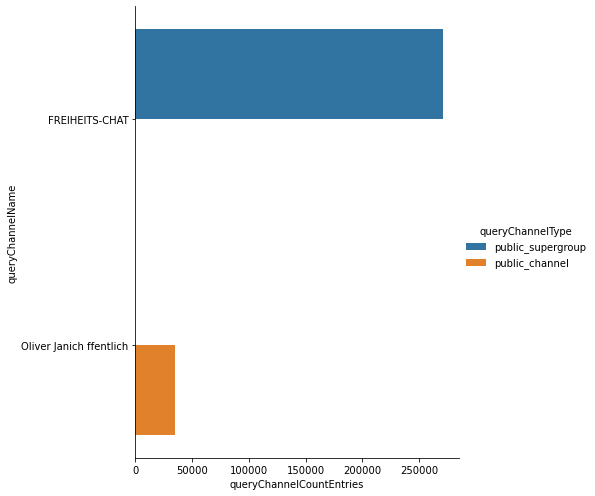

In [32]:
queryPlotter("queryChannelCountEntries")

In [33]:
#queryPlotter("queryChannelPercentRawText")

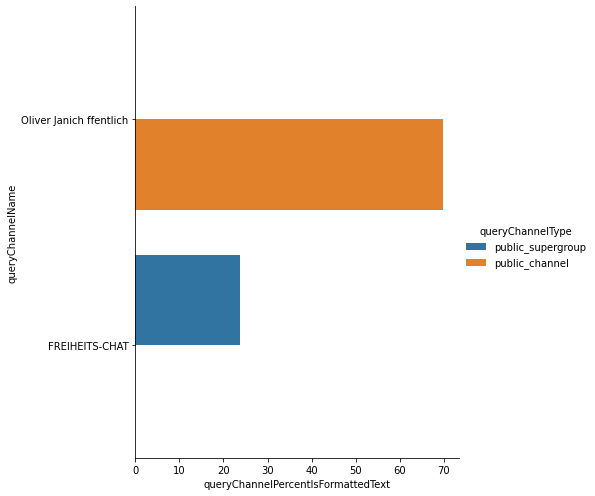

In [34]:
queryPlotter("queryChannelPercentIsFormattedText")

In [35]:
#queryPlotter("queryChannelPercentValidText") 

In [36]:
#queryPlotter("queryChannelPercentPhoto")

In [37]:
#queryPlotter("queryChannelPercentFile")

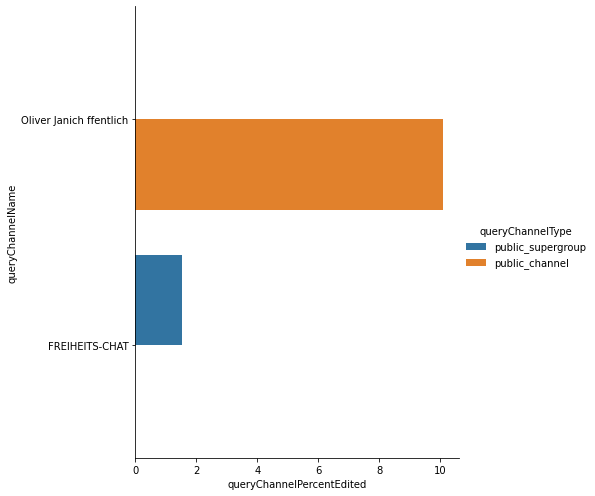

In [38]:
queryPlotter("queryChannelPercentEdited")

## Get valid text

In [39]:
def normalizedValidTextSize(df):
    df = df.copy()
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    return df[np.abs(df.processedValidTextSize-df.processedValidTextSize.mean()) <= (3*df.processedValidTextSize.std())]

Before all filters		306594
Before normalizedValidTextSize	168759
After normalizedValidTextSize	165281


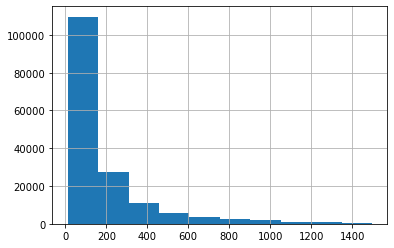

In [40]:
dfMessages = dfAllDataMessages.copy()
print("Before all filters\t\t" + str(len(dfMessages.index)))

dfMessages = dfMessages[dfMessages.processedValidTextSize > 10]
print("Before normalizedValidTextSize\t" + str(len(dfMessages.index)))

dfMessages = normalizedValidTextSize(dfMessages)
print("After normalizedValidTextSize\t" + str(len(dfMessages.index)))

_ = dfMessages.processedValidTextSize.hist()

## Word Clouds

In [60]:
#TODO Difference capital letters?
#TODO Context?

# Use "global" for all DataFrames
def plotChannelWordCloud(filePath):
    timeStart = time.time()
    
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    print("[Start transform text to global text string]")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["processedValidText"])
        
    textString = ''.join(textList)
    
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    
    print("[Start generate wordCloud]")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    
    print("Top 10 occ:\n" + str(pd.Series(wordcloud.words_).head(10)))
    
    print("[Start generate figure]")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
ja          1.000000
mehr        0.959060
Menschen    0.916104
gibt        0.823233
mal         0.760714
schon       0.739336
immer       0.666431
geht        0.665020
Attila      0.625492
Wer         0.550267
dtype: float64
[Start generate figure]


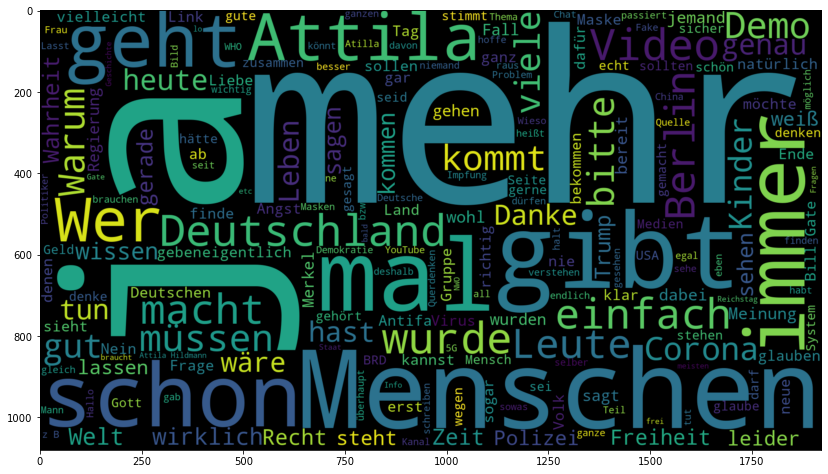

[Finished]
55.486s


In [61]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
mehr           1.000000
wurde          0.919847
Deutschland    0.858355
sei            0.779050
Video          0.648007
sagte          0.627651
Menschen       0.606022
schon          0.546226
gibt           0.542409
Polizei        0.503817
dtype: float64
[Start generate figure]


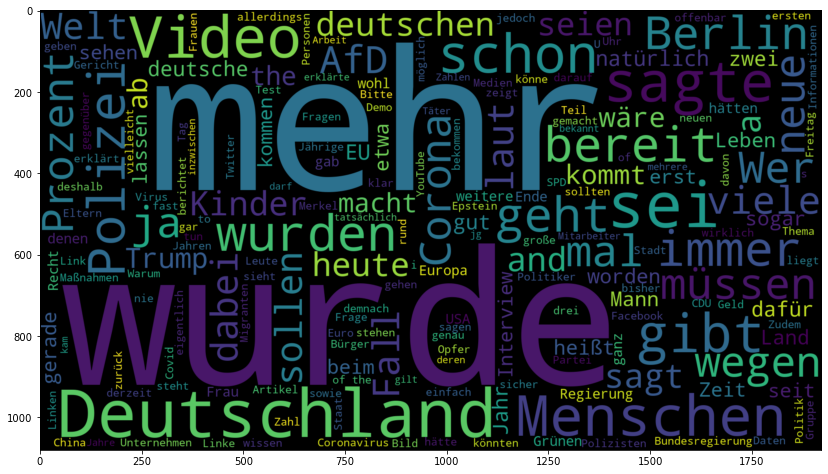

[Finished]
15.799s


In [62]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-janich")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
mehr           1.000000
ja             0.900891
Menschen       0.878578
gibt           0.813803
schon          0.731817
mal            0.697310
geht           0.656145
immer          0.652080
Deutschland    0.607974
wurde          0.567240
dtype: float64
[Start generate figure]


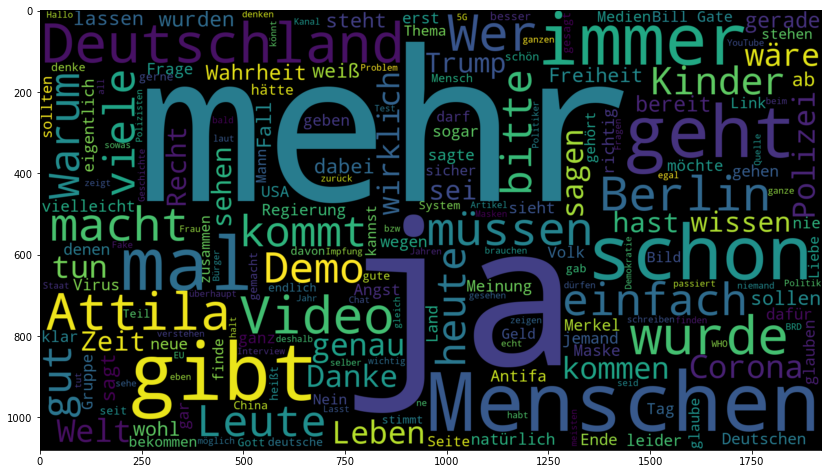

[Finished]
62.866s


In [63]:
plotChannelWordCloud("global")

In [ ]:
#plotChannelWordCloud("#DS-08-10-2020/ChatExport_2020-09-27-evaherman")

In [ ]:
#plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-hildmann")

In [ ]:
#plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-xavier")